In [0]:
#importing libraries
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from statistics import mean 
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

In [0]:
#mounting my drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
X1 =  np.load('/content/drive/My Drive/normalized_phase_diff.npy')
X2 = np.load('/content/drive/My Drive/normalized_amplitude_reshaped.npy')
y =  np.load('/content/drive/My Drive/labels.npy')

INPUT_COUNT = X1.shape[1]
X1 = X1 - np.transpose(X1.mean(axis=1).repeat(INPUT_COUNT).reshape(INPUT_COUNT, -1))
X1 = np.absolute(X1)

X2 = X2 - np.transpose(X2.mean(axis=1).repeat(INPUT_COUNT).reshape(INPUT_COUNT, -1))
X2 = np.absolute(X2)

X = np.append(X1, X2, axis=1)

del X1, X2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1999596)

del X, y


INPUT_COUNT = X_test.shape[1]


train = np.append(X_train, y_train.reshape(-1, 1), axis=1)

del X_train

nonPS = train[y_train==0]
PS = train[y_train==1]

del train, y_train

train_samples=[]

data_size = 60*len(PS)
ratios = []

cric = 15 #positive critical point of the equation  1+(m-1)(max(0, m-3)+1)<=188 rounded off to nearest integer

for i in range(1, cric+1):
  ratio_num = 1 + (i-1)*(max(0, i-3) + 1)
  major = ratio_num*data_size/(ratio_num+1)
  minor = data_size/(ratio_num+1)
  ratios.append([major, minor])


for ratio in ratios:

  nonPS_sample = resample(nonPS, n_samples=int(ratio[0]))
  PS_sample = resample(PS, n_samples=int(ratio[1]))

  train_sample = torch.tensor(np.append(nonPS_sample, PS_sample, axis=0))

  np.random.shuffle(train_sample)

  train_samples.append(train_sample)

del nonPS, PS


test_samples=torch.tensor(np.append(X_test, y_test.reshape(-1, 1), axis=1))

del X_test, y_test

In [0]:
#class to instantnize network object
class Net(nn.Module):
    def __init__(self, h_layers):
        super().__init__()

        self.h_layers = h_layers
        
        self.input = nn.Sequential(
            nn.Linear(INPUT_COUNT, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        
        self.hidden = nn.ModuleList()
        for k in range(h_layers-1):
            self.hidden.append(nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        ))
        
        self.output = nn.Linear(512, 1) if h_layers>0 else nn.Linear(INPUT_COUNT, 1)
        
        self.drop_layer = nn.Dropout(p=0.25)
    
    def forward(self, X):#forward propogation through network

        if self.h_layers:
          X = self.input(X)
          X = self.drop_layer(X)
        for layer in self.hidden:
          X = layer(X)
          X = self.drop_layer(X)
        X = self.output(X)
        return torch.sigmoid(X)

In [0]:
# function to calculate metrics for current batch
def calc_metrics(y_pred, y_true):
  epsilon = 1e-7
  '''rounded each element to either 0 for less than 0.5 or 1 for greater than 0.5'''
  y_pred = torch.round(y_pred)

  
  tp = (y_true * y_pred).sum() # true positive
  fp = ((1-y_true) * y_pred).sum() # false positive
  fn = (y_true * (1-y_pred)).sum()# calculating false negative

  precision = tp / (tp + fp + epsilon)
  recall = tp / (tp + fn + epsilon )
  f1 = 2*tp / (2*tp + fp + fn + epsilon)

  return f1, precision, recall


In [0]:
#class to create F1_loss object instance
class F1_Loss(nn.Module):
    
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true,):
        
        tp = (y_true * y_pred).sum()
        fp = ((1 - y_true) * y_pred).sum()
        fn = (y_true * (1 - y_pred)).sum()


        f1 = 2*tp / (2*tp + fp + fn + self.epsilon)
        return 1 - f1

f1_loss = F1_Loss()

In [0]:
#instantizing loss_function 
loss_function = f1_loss

In [0]:
#function to calculate loss and metrics
def calc_loss_n_metrics(outputs, batch_y):
  outputs = outputs.view(-1)
  loss = loss_function(outputs, batch_y)
  f1, precision, recall = calc_metrics(outputs, batch_y)
  return loss, f1, precision, recall

In [0]:
#function to pass batch through network with some additional arguments
def fwd_pass(net, optimizer, batch_X, batch_y, train):
    
    if train:
      net.train()
      net.zero_grad()
      outputs = net(batch_X)
      loss, f1, precision, recall = calc_loss_n_metrics(outputs, batch_y)
      loss.backward()
      optimizer.step()  
    
    else:
      net.eval()
      with torch.no_grad():
        outputs = net(batch_X)
      loss, f1, precision, recall = calc_loss_n_metrics(outputs, batch_y)
    
    

    return loss, f1, precision, recall

In [0]:
# completing one epoch through the given dataset
def one_epoch(net, optimizer, X, y, BATCH_SIZE, train=False):
  LOSS = []
  F1 = []
  PRECISION = []
  RECALL = []
  for i in range(0, len(X), BATCH_SIZE):
    batch_X = X[i:i+BATCH_SIZE].view(-1, INPUT_COUNT)
    batch_y = y[i:i+BATCH_SIZE].view(-1)
    
    batch_X, batch_y = batch_X.cuda(), batch_y.cuda()

    loss, f1, precision, recall = fwd_pass(net, optimizer, batch_X, batch_y, train)
    LOSS.append(loss)
    F1.append(f1)
    PRECISION.append(precision)
    RECALL.append(recall)
  LOSS = torch.mean(torch.stack(LOSS))
  F1 = torch.mean(torch.stack(F1))
  PRECISION = torch.mean(torch.stack(PRECISION))
  RECALL = torch.mean(torch.stack(RECALL))

  return LOSS, F1, PRECISION, RECALL


In [0]:
METRICS=[]
#function to train the network and save the best model
def train():
    BATCH_SIZE = 32768

    

    for train_sample in tqdm(train_samples):
      #instantizing network
      net = Net(3).cuda()
      #intializing optimimzer instance
      optimizer = optim.Adam(net.parameters())
      best_val_loss=None
      #instantizing TRAINING and VALIDATION lists to save metrics
      threshold=30
      while(True):
          epoch_training_loss, epoch_training_f1, epoch_training_precision, epoch_training_recall = one_epoch(net, optimizer, train_sample[:,0:-1], train_sample[:,-1], BATCH_SIZE, True)
          
          print('training_loss: ', epoch_training_loss)    
          print('training_f1: ', epoch_training_f1)
          print('training_precision: ', epoch_training_precision)
          print('training_recall: ', epoch_training_recall)
          
          epoch_val_loss, epoch_val_f1, epoch_val_precision, epoch_val_recall = one_epoch(net, optimizer, test_samples[:,0:-1], test_samples[:,-1], BATCH_SIZE, False)
          
          print('val_loss: ', epoch_val_loss)
          print('val_f1: ', epoch_val_f1)
          print('val_precision: ', epoch_val_precision)
          print('val_recall: ', epoch_val_recall)

          if not best_val_loss:
            best_val_loss = epoch_val_loss + 1

          is_best = epoch_val_loss < best_val_loss
          best_val_loss = min(epoch_val_loss, best_val_loss)

          if is_best:
            print('BEST VALIDATION LOSS')
            counter=0
            best_loss = epoch_val_loss.item()
            best_f1 = epoch_val_f1.item()
            corr_precision = epoch_val_precision.item()
            corr_recall = epoch_val_recall.item()
            
          counter += 1
          if(counter==threshold):
            METRICS.append([best_loss, best_f1, corr_precision, corr_recall])
            break



In [0]:
#training network
train()

  0%|          | 0/15 [00:00<?, ?it/s]

training_loss:  tensor(0.7195, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.2853, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.2670, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.3565, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9764, device='cuda:0')
val_f1:  tensor(0.0237, device='cuda:0')
val_precision:  tensor(0.0120, device='cuda:0')
val_recall:  tensor(0.8983, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.6921, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.3092, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.2925, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.4137, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9112, device='cuda:0')
val_f1:  tensor(0.0931, device='cuda:0')
val_precision:  tensor(0.0500, device='cuda:0')
val_recall:  tensor(0.6755, device='cuda:0')
BEST VALIDATION LOSS
training_l

  7%|▋         | 1/15 [11:31<2:41:22, 691.59s/it]

val_loss:  tensor(0.8562, device='cuda:0')
val_f1:  tensor(0.1442, device='cuda:0')
val_precision:  tensor(0.0799, device='cuda:0')
val_recall:  tensor(0.7446, device='cuda:0')
training_loss:  tensor(0.8563, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.1485, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.1303, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.2227, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9782, device='cuda:0')
val_f1:  tensor(0.0222, device='cuda:0')
val_precision:  tensor(0.0112, device='cuda:0')
val_recall:  tensor(0.8848, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.8317, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.1696, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.1569, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.2446, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9596, devic

 13%|█▎        | 2/15 [22:53<2:29:11, 688.56s/it]

val_loss:  tensor(0.8217, device='cuda:0')
val_f1:  tensor(0.1788, device='cuda:0')
val_precision:  tensor(0.1036, device='cuda:0')
val_recall:  tensor(0.6585, device='cuda:0')
training_loss:  tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0900, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0731, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.1671, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9813, device='cuda:0')
val_f1:  tensor(0.0192, device='cuda:0')
val_precision:  tensor(0.0097, device='cuda:0')
val_recall:  tensor(0.8919, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.8907, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.1112, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.1016, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.1748, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9533, devic

 20%|██        | 3/15 [27:34<1:53:16, 566.40s/it]

val_loss:  tensor(0.8230, device='cuda:0')
val_f1:  tensor(0.1770, device='cuda:0')
val_precision:  tensor(0.1036, device='cuda:0')
val_recall:  tensor(0.6127, device='cuda:0')
training_loss:  tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0215, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0129, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.1048, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9819, device='cuda:0')
val_f1:  tensor(0.0200, device='cuda:0')
val_precision:  tensor(0.0101, device='cuda:0')
val_recall:  tensor(0.7606, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0325, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0248, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0687, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9587, devic

 27%|██▋       | 4/15 [31:32<1:25:46, 467.88s/it]

val_loss:  tensor(0.8586, device='cuda:0')
val_f1:  tensor(0.1424, device='cuda:0')
val_precision:  tensor(0.0803, device='cuda:0')
val_recall:  tensor(0.6347, device='cuda:0')
training_loss:  tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0069, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0038, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0686, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9819, device='cuda:0')
val_f1:  tensor(0.0219, device='cuda:0')
val_precision:  tensor(0.0112, device='cuda:0')
val_recall:  tensor(0.4474, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9909, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0093, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0575, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9824, devic

 33%|███▎      | 5/15 [35:57<1:07:50, 407.08s/it]

val_loss:  tensor(0.8746, device='cuda:0')
val_f1:  tensor(0.1260, device='cuda:0')
val_precision:  tensor(0.0701, device='cuda:0')
val_recall:  tensor(0.6251, device='cuda:0')
training_loss:  tensor(0.9972, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0030, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0357, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9853, device='cuda:0')
val_f1:  tensor(0.0214, device='cuda:0')
val_precision:  tensor(0.0110, device='cuda:0')
val_recall:  tensor(0.3899, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9962, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0038, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0021, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0435, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9849, devic

 40%|████      | 6/15 [42:21<1:00:01, 400.22s/it]

val_loss:  tensor(0.8342, device='cuda:0')
val_f1:  tensor(0.1660, device='cuda:0')
val_precision:  tensor(0.1045, device='cuda:0')
val_recall:  tensor(0.4066, device='cuda:0')
training_loss:  tensor(0.9987, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0084, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9869, device='cuda:0')
val_f1:  tensor(0.0193, device='cuda:0')
val_precision:  tensor(0.0099, device='cuda:0')
val_recall:  tensor(0.3640, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9982, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0294, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9840, devic

 47%|████▋     | 7/15 [48:18<51:38, 387.29s/it]  

val_loss:  tensor(0.8387, device='cuda:0')
val_f1:  tensor(0.1612, device='cuda:0')
val_precision:  tensor(0.1263, device='cuda:0')
val_recall:  tensor(0.2239, device='cuda:0')
training_loss:  tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0150, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9880, device='cuda:0')
val_f1:  tensor(0.0202, device='cuda:0')
val_precision:  tensor(0.0111, device='cuda:0')
val_recall:  tensor(0.1173, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9989, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0312, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9849, devic

 53%|█████▎    | 8/15 [54:21<44:19, 379.86s/it]

val_loss:  tensor(0.8916, device='cuda:0')
val_f1:  tensor(0.1085, device='cuda:0')
val_precision:  tensor(0.1396, device='cuda:0')
val_recall:  tensor(0.0891, device='cuda:0')
training_loss:  tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0216, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9884, device='cuda:0')
val_f1:  tensor(0.0122, device='cuda:0')
val_precision:  tensor(0.0243, device='cuda:0')
val_recall:  tensor(0.0082, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0332, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9864, devic

 60%|██████    | 9/15 [1:00:29<37:37, 376.32s/it]

val_loss:  tensor(0.8716, device='cuda:0')
val_f1:  tensor(0.1287, device='cuda:0')
val_precision:  tensor(0.1521, device='cuda:0')
val_recall:  tensor(0.1122, device='cuda:0')
training_loss:  tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0129, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9889, device='cuda:0')
val_f1:  tensor(0.0138, device='cuda:0')
val_precision:  tensor(0.0070, device='cuda:0')
val_recall:  tensor(0.4054, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9996, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0165, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9866, devic

 67%|██████▋   | 10/15 [1:05:43<29:48, 357.64s/it]

val_loss:  tensor(0.9361, device='cuda:0')
val_f1:  tensor(0.0636, device='cuda:0')
val_precision:  tensor(0.1547, device='cuda:0')
val_recall:  tensor(0.0402, device='cuda:0')
training_loss:  tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(8.2598e-05, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0139, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9890, device='cuda:0')
val_f1:  tensor(0.0142, device='cuda:0')
val_precision:  tensor(0.0074, device='cuda:0')
val_recall:  tensor(0.2015, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9998, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0179, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9878, d

 73%|███████▎  | 11/15 [1:12:40<25:02, 375.53s/it]

val_loss:  tensor(0.9761, device='cuda:0')
val_f1:  tensor(0.0236, device='cuda:0')
val_precision:  tensor(0.1539, device='cuda:0')
val_recall:  tensor(0.0128, device='cuda:0')
training_loss:  tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(7.3983e-05, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(3.7088e-05, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0142, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9891, device='cuda:0')
val_f1:  tensor(0.0156, device='cuda:0')
val_precision:  tensor(0.0087, device='cuda:0')
val_recall:  tensor(0.0770, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(6.1269e-05, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0172, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0

 80%|████████  | 12/15 [1:16:28<16:33, 331.08s/it]

val_loss:  tensor(1.0000, device='cuda:0')
val_f1:  tensor(0., device='cuda:0')
val_precision:  tensor(0., device='cuda:0')
val_recall:  tensor(0., device='cuda:0')
training_loss:  tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(9.8356e-05, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(4.9394e-05, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0112, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9891, device='cuda:0')
val_f1:  tensor(0.0151, device='cuda:0')
val_precision:  tensor(0.0078, device='cuda:0')
val_recall:  tensor(0.2305, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9998, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(9.2559e-05, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0185, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9872, devic

 87%|████████▋ | 13/15 [1:20:31<10:09, 304.84s/it]

val_loss:  tensor(1.0000, device='cuda:0')
val_f1:  tensor(0., device='cuda:0')
val_precision:  tensor(0., device='cuda:0')
val_recall:  tensor(0., device='cuda:0')
training_loss:  tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(5.4826e-05, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(2.7471e-05, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0129, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9889, device='cuda:0')
val_f1:  tensor(0.0182, device='cuda:0')
val_precision:  tensor(0.0098, device='cuda:0')
val_recall:  tensor(0.1332, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(5.3132e-05, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0174, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9875, devic

 93%|█████████▎| 14/15 [1:23:52<04:33, 273.55s/it]

val_loss:  tensor(1.0000, device='cuda:0')
val_f1:  tensor(0., device='cuda:0')
val_precision:  tensor(0., device='cuda:0')
val_recall:  tensor(0., device='cuda:0')
training_loss:  tensor(1.0000, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(4.5642e-05, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(2.2849e-05, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0182, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9891, device='cuda:0')
val_f1:  tensor(0.0158, device='cuda:0')
val_precision:  tensor(0.0085, device='cuda:0')
val_recall:  tensor(0.1248, device='cuda:0')
BEST VALIDATION LOSS
training_loss:  tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
training_f1:  tensor(7.8144e-05, device='cuda:0', grad_fn=<MeanBackward0>)
training_precision:  tensor(3.9147e-05, device='cuda:0', grad_fn=<MeanBackward0>)
training_recall:  tensor(0.0203, device='cuda:0', grad_fn=<MeanBackward0>)
val_loss:  tensor(0.9878, d

100%|██████████| 15/15 [1:29:56<00:00, 300.66s/it]

val_loss:  tensor(0.9938, device='cuda:0')
val_f1:  tensor(0.0064, device='cuda:0')
val_precision:  tensor(0.0100, device='cuda:0')
val_recall:  tensor(0.0047, device='cuda:0')


In [0]:
ratio_nums=[]
for i in range(1, cric+1):
  ratio_num = 1 + (i-1)*(max(0, i-3) + 1)
  ratio_nums.append(ratio_num)

METRICS = np.array(METRICS)
METRICS=np.transpose(METRICS)
ratio_nums = np.array(ratio_nums)

torch.save({    
    'metrics': METRICS,
    'ratios': ratio_nums
            }, F"/content/drive/My Drive/class_ratios.pt" )


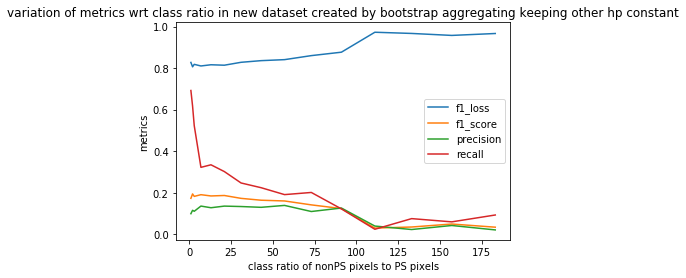

In [0]:
checkpoint = torch.load("/content/drive/My Drive/class_ratios.pt")
METRICS = checkpoint['metrics']
ratio_nums = checkpoint['ratios']
plt.plot(ratio_nums, METRICS[0], label='f1_loss')
plt.plot(ratio_nums, METRICS[1], label='f1_score')
plt.plot(ratio_nums, METRICS[2], label='precision')
plt.plot(ratio_nums, METRICS[3], label='recall')
plt.title('variation of metrics wrt class ratio in new dataset created by bootstrap aggregating keeping other hp constant')
plt.xlabel('class ratio of nonPS pixels to PS pixels')
plt.ylabel('metrics')
plt.legend()
plt.show()

In [0]:
ratio_max_f1 = ratio_nums[np.argmax(METRICS[1])]
max_f1 = METRICS[1][np.argmax(METRICS[1])]
corr_pr = METRICS[2][np.argmax(METRICS[1])]
corr_recall = METRICS[3][np.argmax(METRICS[1])]

print(ratio_max_f1, max_f1, corr_pr, corr_recall)

2 0.19400696456432343 0.11523115634918213 0.617501437664032
